In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scanpy as sc
import matplotlib.gridspec as gridspec
import pickle
 

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#%matplotlib inline
sc.settings.figdir = "supp"
sc.settings.set_figure_params(dpi_save=300, facecolor="white", frameon=False, figsize=(25,25))


# Load data

In [3]:
FILE_NAME = "adata_combined_new.h5ad.final.filtered"
PATH2=f'/nfs/team298/ls34/adult_skin/final_adatas/{FILE_NAME}'
adata_5k=sc.read_h5ad(PATH2)
adata_5k=adata_5k[adata_5k.obs["tech"]=="xenium"]

def remove_markers(LIST):
    try: 
        LIST = {key: [gene for gene in genes if gene in adata_5k.var_names] 
                           for key, genes in LIST.items()}
    except: 
        LIST =[gene for gene in LIST if gene in adata_5k.var_names]
    return LIST


 


# Remove niche where skin folded 

In [4]:
adata_5k=adata_5k[adata_5k.obs["niche19"]!= 'Nonspecific/folded'].copy()
NICHE = "niche19"
adata_5k.obs["niche19"].value_counts()

niche19
Small_BV                    292507
Papillary_dermis            180739
Epidermis_basal             147213
Epidermis_mid               133572
Epidermis_late              109007
Reticular_dermis             83279
Tzone-like                   73950
EpidermisInflamm_mid         72774
Sweat_gland                  46573
Sweat_gland_channel          44440
Muscle                       40225
Sebaceous_duct               33977
Large_BV                     27079
Reticular_dermis_LE_rich     26098
Perineural                   20405
HF_outer                     19947
Hypodermis                   15600
VenuleMuscle                 14906
Sebaceous_gland              13163
Epidermis_basal_cycling      10415
EpidermisInflamm_late         4396
Sebaceous_immune              3459
HF_inner                      2424
Epidermis_APChi                664
Plasma_cell_rich               565
HF_innermost                   119
Name: count, dtype: int64

In [5]:
# [x for x in adata_5k.obs["lvl5_annotation"].unique() if x.startswith("ILC")]

In [6]:
adata_5k.obs["Site_status"].value_counts()

Site_status
Non-lesional                        365833
Lesional                            231613
3D_Week12                           179026
3D_Lesional_baseline                153479
Week 12                             139630
Psoriasis_replicate_non-lesional     76048
Week 8 Psoriasis                     72092
Psoriasis_replicate_Lesional         60640
Healthy                              59315
Psoriasis_replicate_PostRx           49382
Day 14_HF                            30438
Name: count, dtype: int64

In [7]:
CATEGORY="lvl5_annotation"

# Compare niche composition

In [8]:
adata_5k_i = adata_5k[          (adata_5k.obs["Site_status"].str.startswith("Lesional"))|
                    (adata_5k.obs["disease_overall"].str.startswith("3D_Lesional_baseline"))|

                    (adata_5k.obs["Site_status"].str.startswith("Psoriasis_replicate_Lesional"))
                                          
   
      # (adata_5k.obs["Site_status"]=="Healthy")
                   ]


Site_status
Lesional                        231613
Psoriasis_replicate_Lesional     60640
Name: count, dtype: int64

In [10]:
path = "/nfs/team298/ls34/niche_colors.pkl"
with open(path, "rb") as f:
    colors_new2 = pickle.load(f)



/tmp/ipykernel_2797186/841041710.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["disease_overall", "niche19"])
/tmp/ipykernel_2797186/841041710.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = counts.groupby("disease_overall")["count"].sum().reset_index(name="total")
/tmp/ipykernel_2797186/841041710.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  plot_df = counts.pivot_table(


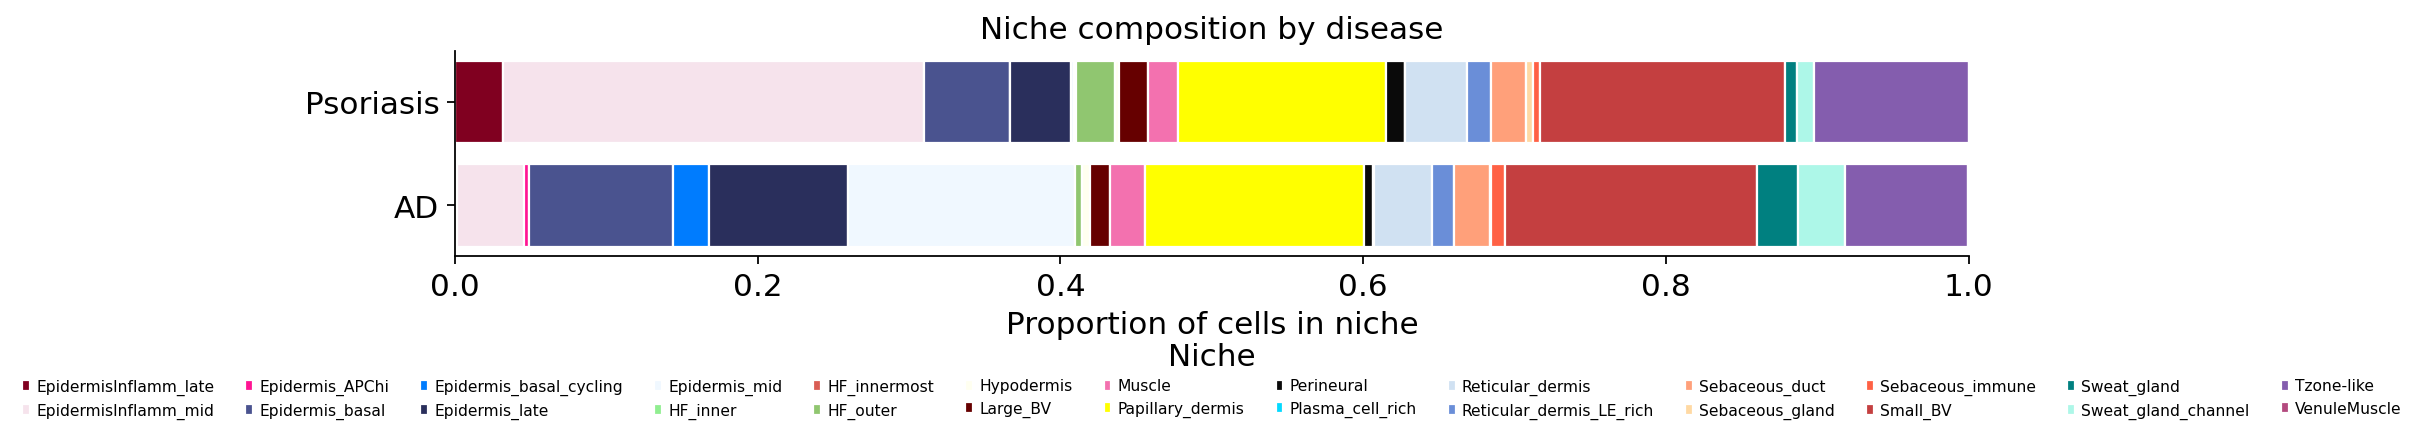

In [11]:
df = adata_5k_i.obs[["disease_overall", "niche19"]].copy()

counts = (
    df.groupby(["disease_overall", "niche19"])
      .size()
      .reset_index(name="count")
)



total_counts = counts.groupby("disease_overall")["count"].sum().reset_index(name="total")
counts = counts.merge(total_counts, on="disease_overall")
counts["prop"] = counts["count"] / counts["total"]

niche_order = counts["niche19"].unique()

plot_df = counts.pivot_table(
    index="disease_overall",
    columns="niche19",
    values="prop",
    fill_value=0
)[niche_order].reset_index()

fig, ax = plt.subplots(figsize=(14, 3.5))  # Increased height slightly for space below

x_offsets = np.zeros(len(plot_df))
fallback = "#d3d3d3"
colors = [colors_new2.get(n, fallback) for n in niche_order]

for i, niche in enumerate(niche_order):
    props = plot_df[niche].values
    ax.barh(
        y=plot_df["disease_overall"],
        width=props,
        left=x_offsets,
        color=colors[i],
        edgecolor="white",
        label=niche
    )
    x_offsets += props

ax.set_xlabel("Proportion of cells in niche")
ax.set_xlim(0, 1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)
ax.set_title("Niche composition by disease")

n_cols = int(np.ceil(len(niche_order) / 2))
ax.legend(
    bbox_to_anchor=(0.5, -0.35),  # Below plot
    loc="upper center",
    ncol=n_cols,
    fontsize=7,
    title="Niche",
    frameon=False
)

plt.tight_layout()
plt.show()

# Nonlesional cell contents

In [12]:
adata_5k_i.obs.Site_status_binary.value_counts()
adata_5k_i=adata_5k[(adata_5k.obs["Site_status"]=="Lesional")
                # (adata_5k.obs["Site_status"].str.startswith("Psoriasis_replicate_non-lesional"))
                   ]
adata_5k_i.obs.Site_status.value_counts()

Site_status
Lesional    231613
Name: count, dtype: int64

In [13]:
adata_5k.obs["niche19"].value_counts()

niche19
Small_BV                    292507
Papillary_dermis            180739
Epidermis_basal             147213
Epidermis_mid               133572
Epidermis_late              109007
Reticular_dermis             83279
Tzone-like                   73950
EpidermisInflamm_mid         72774
Sweat_gland                  46573
Sweat_gland_channel          44440
Muscle                       40225
Sebaceous_duct               33977
Large_BV                     27079
Reticular_dermis_LE_rich     26098
Perineural                   20405
HF_outer                     19947
Hypodermis                   15600
VenuleMuscle                 14906
Sebaceous_gland              13163
Epidermis_basal_cycling      10415
EpidermisInflamm_late         4396
Sebaceous_immune              3459
HF_inner                      2424
Epidermis_APChi                664
Plasma_cell_rich               565
HF_innermost                   119
Name: count, dtype: int64

In [16]:
adata_5k_i = adata_5k_i[(adata_5k_i.obs["lvl0"].str.startswith("T"))|
                     (adata_5k_i.obs[CATEGORY].str.startswith("Plasm"))|
                        (adata_5k_i.obs[CATEGORY].str.startswith("Bcell"))|
                     (adata_5k_i.obs["lvl0"]=="Myeloid")|
                         (adata_5k_i.obs[CATEGORY]=="Mast cell") |
                      (adata_5k_i.obs[CATEGORY]=="LC_ALOX15hi") 
                      

#                (adata_5k.obs["lvl0"]=="Melanocyte")|
 #               (adata_5k.obs["lvl0"]=="Adipocyte")|
  #             (adata_5k.obs["lvl0"]=="Mast cell")|
   #                (adata_5k.obs["lvl0"]=="Plasma cell/Bcell")
               ]
adata_5k_i.shape

desired_order2 =  ['Treg','Treg_LRRC32','Treg_LRRC32+', 'TR1', 'Tnaive','Tnaive1','Tnaive2', 'Tnaive/T_cm', 'Tnaive/Tcm', 'T_polarized_CCR6+','Th', 
                  'Th_PPARGhi',
                  'Th_PPARGhi_IL17+',
                  'Tc',
                 'Tc_IFNGhi',"Tc_ZNF683+",'T_γδ',
            'Tc_IL13','TRM_IL13',"TRM_IL13+",
'TRM_IL17', "TRM_IL17+",'Th/TRM prolif', 'T','T_polarized',
                
                 







                
                 'T_Prolif','T_prolif','Treg/Tnaive_prolif',

'NK', "ILC1/NK","ILC_prolif",
                 
'ILC_Prolif',
          

'ILC1','ILC1_NCR2+P2RX7+','ILC3',
                  'ILC3_CCL1+PTGDS+', 
                  
                          'ILC2',
                  
                  
                'Plasma cell',
                  "Monocyte",
                  'Monocyte?', 'Mac',
                   
                   
                   
                   
                   'Macint','Mac_TREM2+LPL+',
                   
                   
                'Mac1',  'Mac2',


'Tc0','Tc1','Tc2','Tc3_IFNGhi',

                   'Tc_Prolif' ,




 'Mac2_CCL14hi','Mac_CCL14hi','MacCCL14_hi','Mac_LPLhi', 'Mac LPLhi (P2RY12-)',
                  'Mac LPLhi','Mac_TREM+','Mac_Perineural?',"Mac_CX3CR1+",
                  'Mac_prolif/PreDC', 'TransitionalDC',
                   "Mac_prolif/preDC",
'Mac_prolif',
















'cDC',
 'cDC1',
 'cDC2', 'cDC2_MMP12',   'cDC2: MMP12+', 'cDC2: MMP12hi', "cDC2: MMP12+IL1B+",'cDC2: THBS1+', 'cDC2: EREG+CCR7+', 'cDC2_cycling',
                  'MoDC/cDC2','MoDC','cDC2_MoDC(C1QTNF1+KDR+)','cDC2_MoDC (THBS1+)', 'cDC2_THBS1+','LC/MoDC_MMP12+/CXCL9+',
                  'cMoDC/cDC (C1QTNF1+KDR+)','MoDC?','MoDC_lowqithink?',

                   'LC_CCR7+','LC_SLC18A2+',
 'LC','LC_ALOX15hi',
'cDC2_MMP12hi (Mig)','cDC: MMP12+/CXCL9+', 
 'MigDC','MigDC_T_doublet',
                  'MigDC (cDC1)','MigDC (cDC2)',
 'pDC',"Mast cell", "Neutrophil",
                 
                  'DC2/Mac',
                  "Bcell",



 

]


# Ensure 'lvl3_annotation' is categorical
if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
    adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

    
if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
    adata_5k_i.obs[CATEGORY] = adata_5k_i.obs[CATEGORY].astype('category')

missing_data = 0
for x in list(adata_5k_i.obs[CATEGORY].unique()):
    if x not in desired_order2:
        print(x)
        missing_data +=1
if missing_data != 0:
    stop
        
        
# Set the categories in the desired order
adata_5k_i.obs[CATEGORY] = pd.Categorical(
    adata_5k_i.obs[CATEGORY],
    categories=desired_order2,
    ordered=True
)
 
    




/tmp/ipykernel_2797186/3536209915.py:111: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
/tmp/ipykernel_2797186/3536209915.py:115: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(adata_5k_i.obs[CATEGORY]):
/tmp/ipykernel_2797186/3536209915.py:128: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_5k_i.obs[CATEGORY] = pd.Categorical(


In [17]:
all_cell_types = sorted(adata_5k_i.obs["lvl5_annotation"].unique().tolist())
all_cell_types
for x in sorted(adata_5k_i.obs[CATEGORY].unique().tolist()):
    if x not in desired_order2:
        print(x)

In [18]:
mpl.rcParams["axes.grid"] = False  

In [20]:
desired_order = [ #'Epidermis_APChi', 
     'EpidermisInflamm_late', 
    'EpidermisInflamm_mid',

        'Epidermis_basal_cycling',
    'Epidermis_late', 
    
    'Epidermis_mid', 'Epidermis_basal',


    
 'Papillary_dermis',
         'Small_BV',
                  'Tzone-like',

    
 'Reticular_dermis', #'Reticular_dermis_LErich',
                  'Reticular_dermis_LE_rich',


                  'Large_BV', 'VenuleMuscle',
                  'Perineural',
                #  'HF',
               #  'OuterHF',
    'HF_outer', 'HF_inner', #'HF_innermost',
 'Muscle',
 'Sebaceous_gland', 'Sebaceous_duct', 
    'Sebaceous_immune', 
    'Plasma_cell_rich',


   # 'Plasma_cell_niche',


                  'Sweat_gland',
 'Sweat_gland_channel',



# 'Sebaceous_immune',
# 'Epidermis_APChi',
                                   'Hypodermis',

 #'Perifollicular_VE',
 #'Epidermis_basal_immune'
                ]


for x in adata_5k_i.obs[NICHE].unique():
    if x not in desired_order:
        print(x)
desired_order2 = [x for x in desired_order if x in adata_5k_i.obs[NICHE] .unique()]

Epidermis_APChi


Annotations:  lvl5_annotation
AD


/tmp/ipykernel_2797186/3917512299.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2797186/3917512299.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


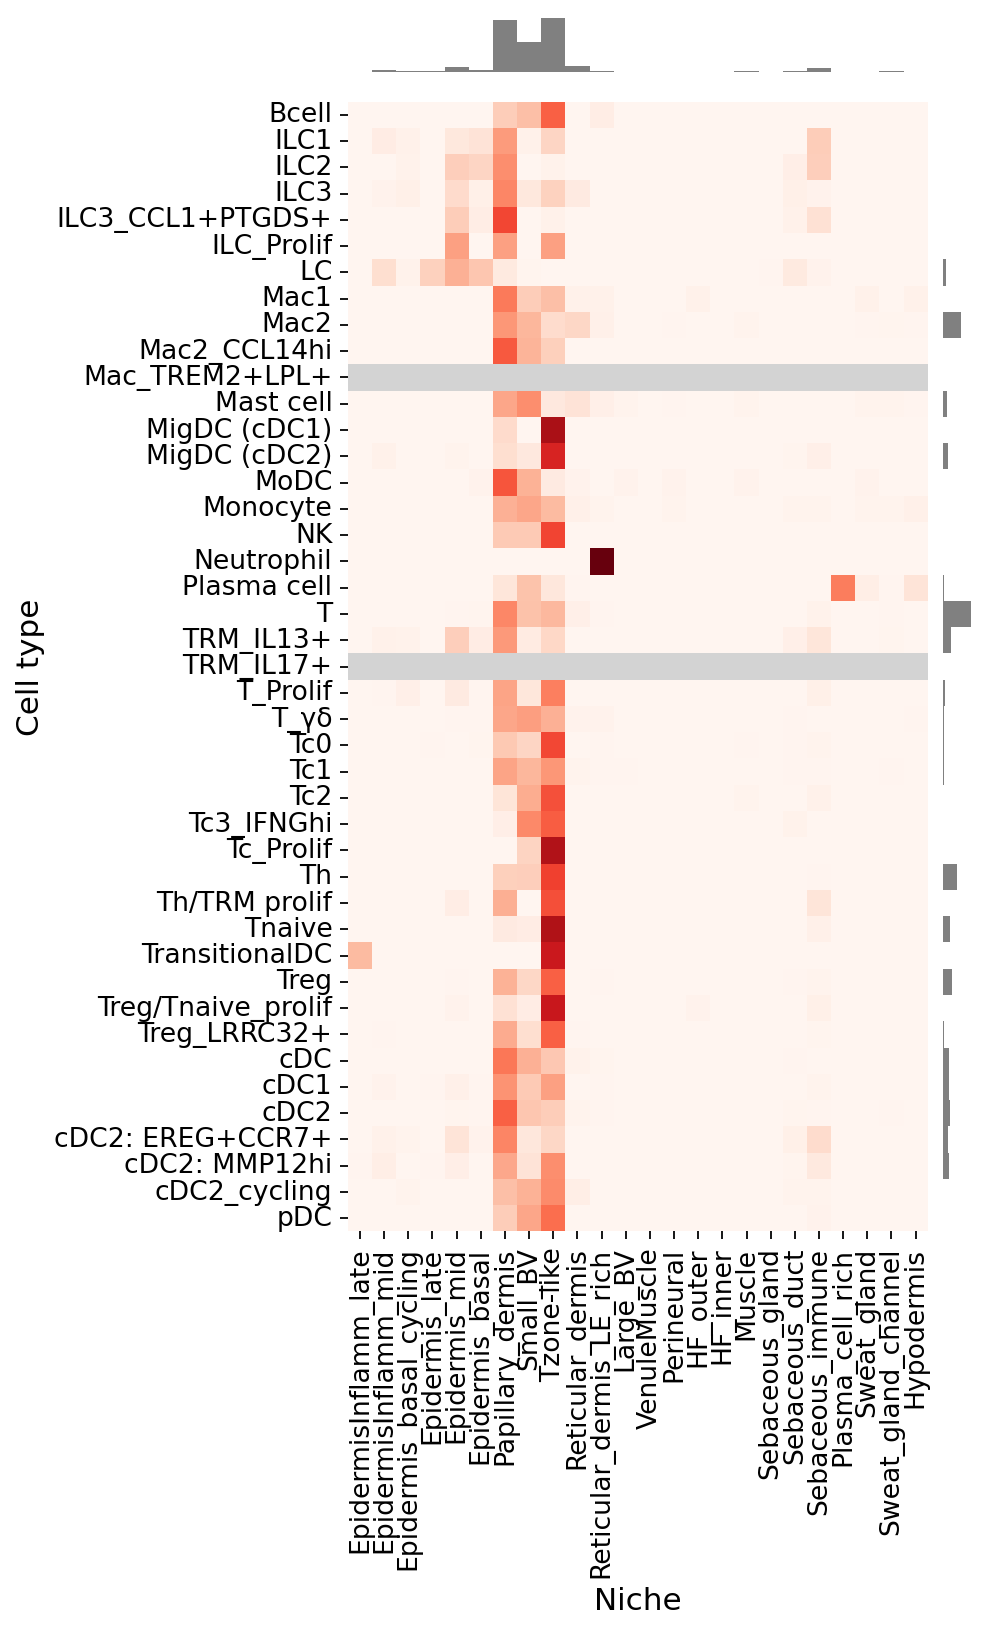

Psoriasis


/tmp/ipykernel_2797186/3917512299.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2797186/3917512299.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


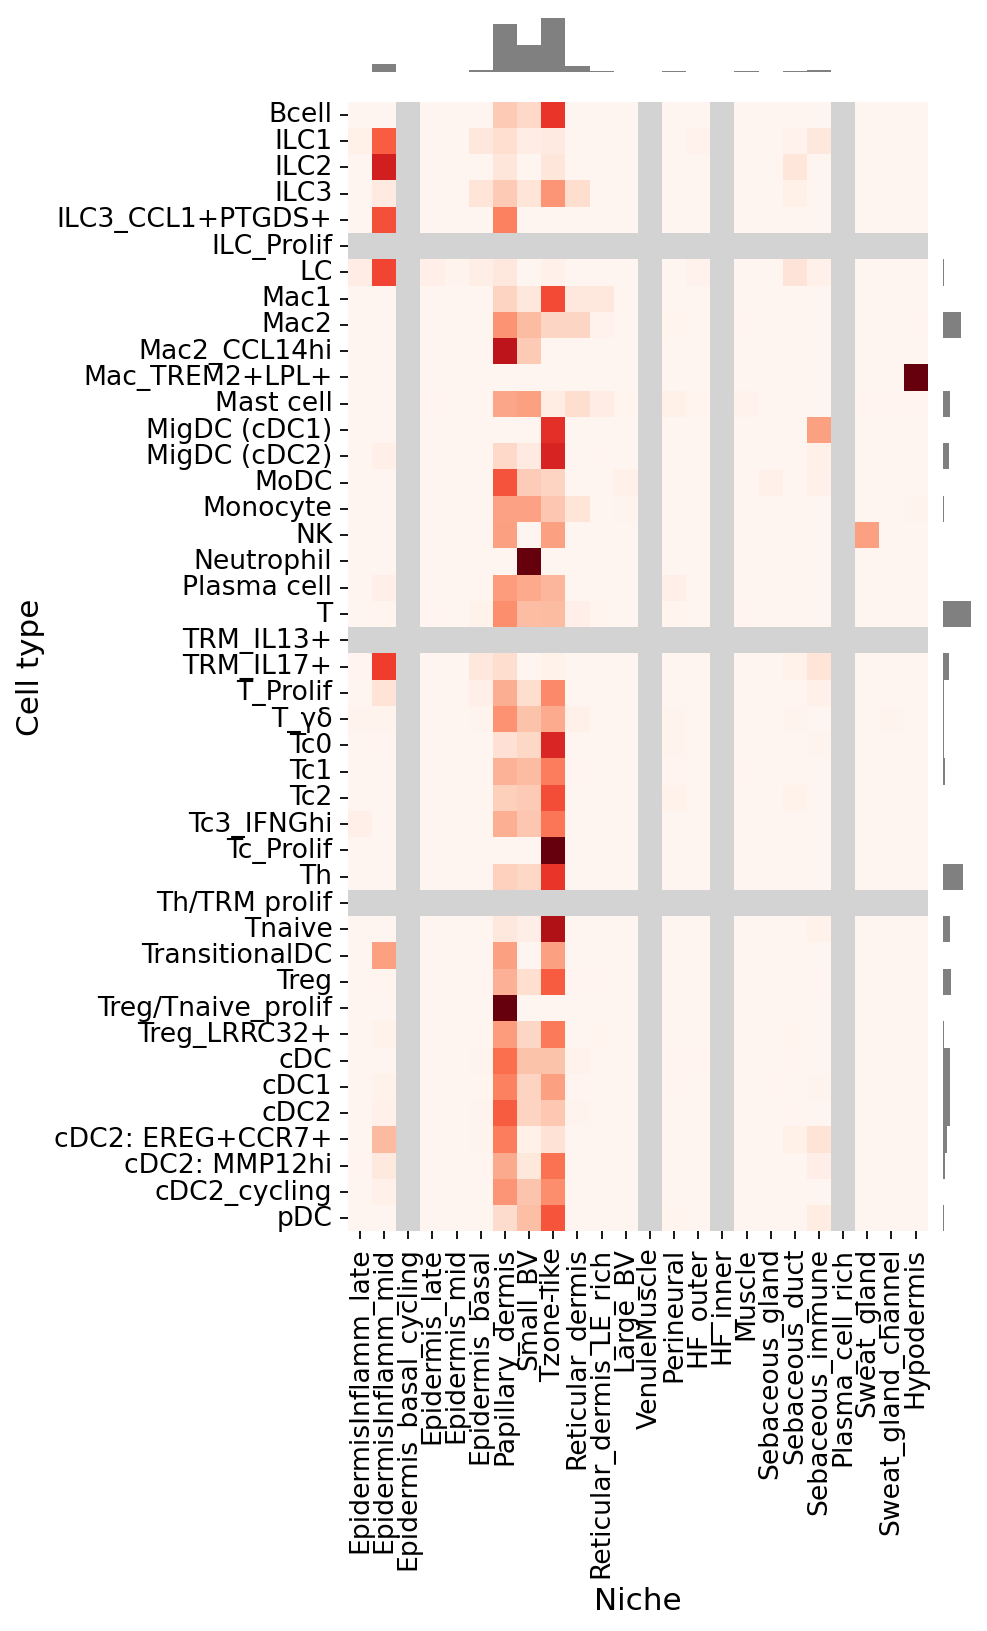

In [21]:
print("Annotations: ", CATEGORY)

# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for DISEASE in ["AD", "Psoriasis"]:
    print(DISEASE)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == DISEASE]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns=NICHE, values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(5
                              ,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, #linecolor='white'
    linecolor=None 
        
    )
    ax_heat.set_xlabel('Niche', fontsize=14)
    ax_heat.set_ylabel('Cell type', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)
    ax_heat.set_facecolor('white')  # removes background tint behind NaNs
    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"supp/5a_immuneniches_{DISEASE}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

Annotations:  lvl5_annotation
AD


/tmp/ipykernel_2797186/1649264119.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2797186/1649264119.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


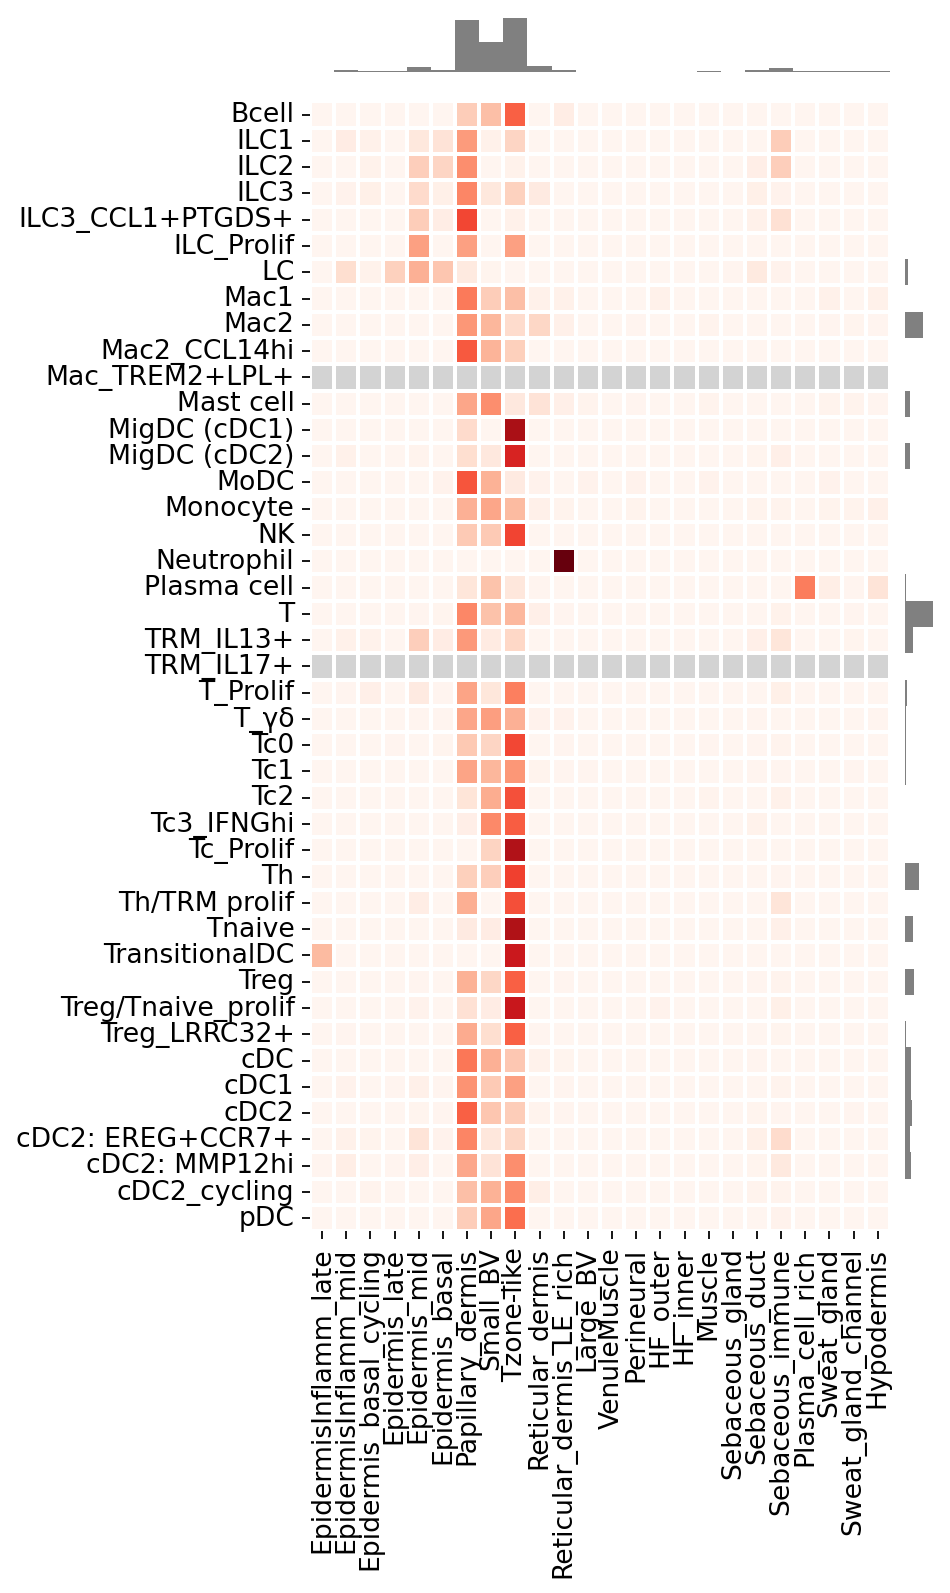

Psoriasis


/tmp/ipykernel_2797186/1649264119.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2797186/1649264119.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


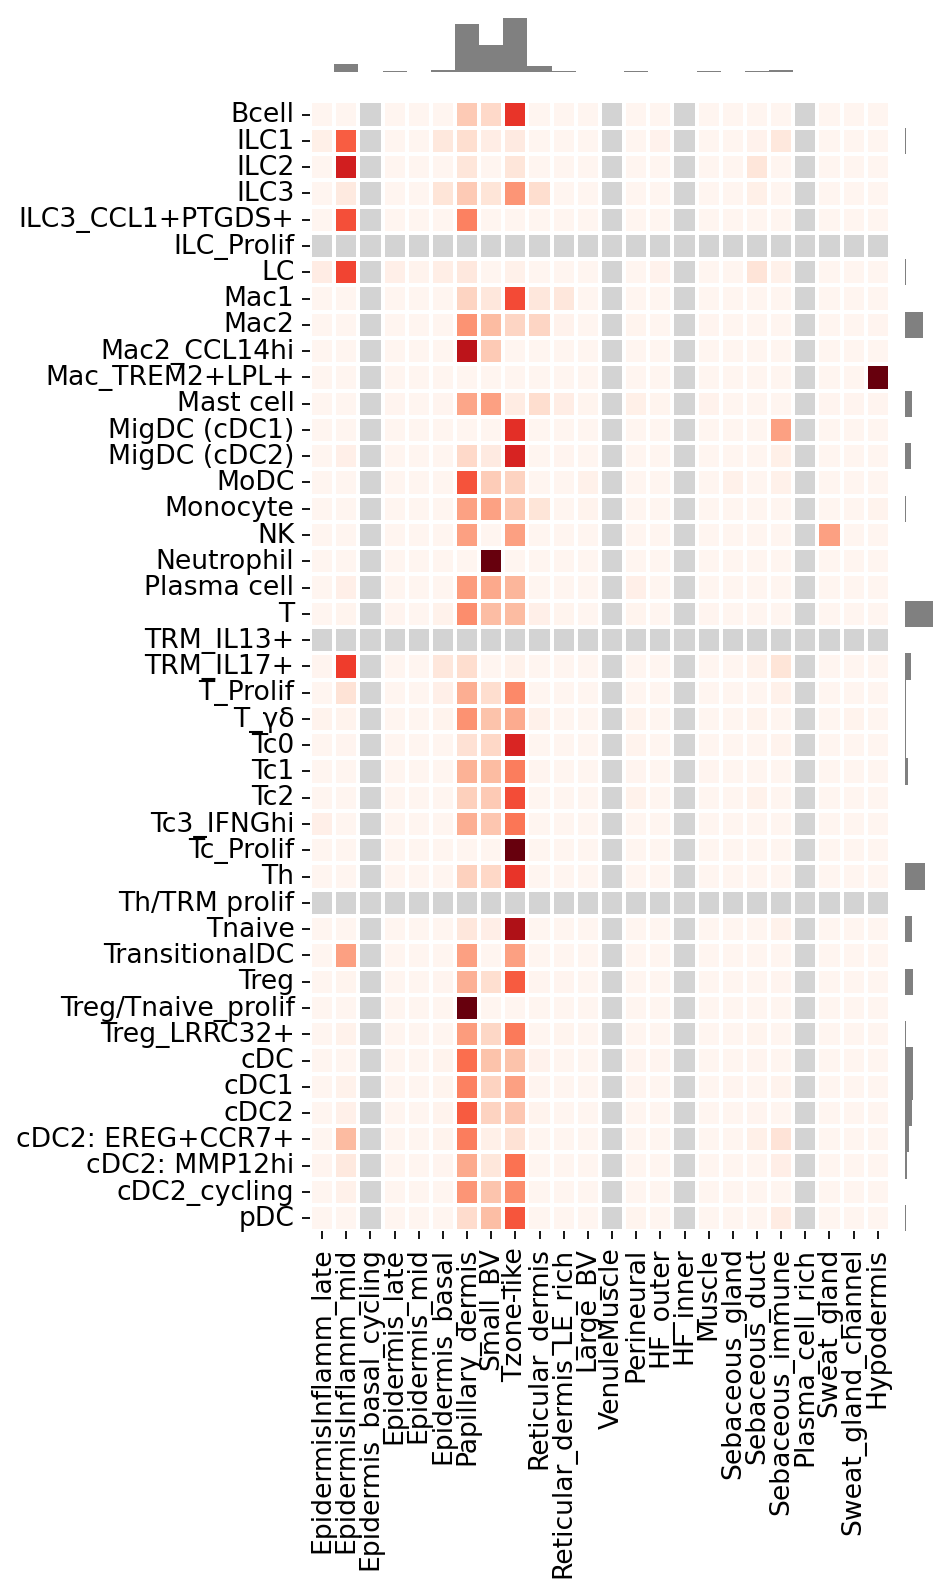

In [22]:
print("Annotations: ", CATEGORY)

# ---- Desired row and column order ----
all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for DISEASE in ["AD", "Psoriasis"]:
    print(DISEASE)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == DISEASE]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns=NICHE, values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(5
                              ,10))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, 
        linecolor='white'
   # linecolor=None 
        
    )
    ax_heat.set_xlabel('', fontsize=14)
    ax_heat.set_ylabel('', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)
    ax_heat.set_facecolor('white')  # removes background tint behind NaNs
    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"supp/5a_immuneniches__{DISEASE}_grid.pdf", dpi=300, bbox_inches="tight")
    plt.show()

In [23]:
IMMUNE_CELLS = adata_5k_i.obs["lvl5_annotation"].unique().tolist()


['cDC2: MMP12hi',
 'LC',
 'T',
 'Mac2',
 'Mast cell',
 'cDC2',
 'TRM_IL13+',
 'cDC1',
 'T_Prolif',
 'Th',
 'Tnaive',
 'Tc1',
 'Treg',
 'Mac2_CCL14hi',
 'Treg/Tnaive_prolif',
 'T_γδ',
 'cDC',
 'MigDC (cDC2)',
 'Mac1',
 'ILC3',
 'cDC2: EREG+CCR7+',
 'Treg_LRRC32+',
 'pDC',
 'cDC2_cycling',
 'Tc3_IFNGhi',
 'Tc0',
 'Tc2',
 'MoDC',
 'ILC2',
 'Monocyte',
 'ILC1',
 'Plasma cell',
 'Th/TRM prolif',
 'Bcell',
 'ILC3_CCL1+PTGDS+',
 'TransitionalDC',
 'Tc_Prolif',
 'MigDC (cDC1)',
 'NK',
 'ILC_Prolif',
 'Neutrophil',
 'TRM_IL17+',
 'Mac_TREM2+LPL+']

# Lesional: Non-immune

In [25]:
adata_5k_i = adata_5k[          #(adata_5k.obs["Timepoint"].str.startswith("Past"))|

                  
                                            (adata_5k.obs["Site_status"].str.startswith("Les"))
                                                    #  (adata_5k.obs["Site_status"].str.startswith("Never"))|
                      #     (adata_5k.obs["Site_status"].str.startswith("Non"))|
    #   (adata_5k.obs["Site_status"]=="Healthy")
                   ]
#adata_5k.obs["Site_status"].value_counts()
adata_5k_i.obs["Site_status"].value_counts()

Site_status
Lesional    231613
Name: count, dtype: int64

In [26]:
adata_5k_i=adata_5k_i[~adata_5k_i.obs["lvl5_annotation"].isin(IMMUNE_CELLS)]
adata_5k_i.obs["lvl5_annotation"].value_counts()
# adata_5k_i = adata_5k[#(adata_5k.obs["lvl0"].str.startswith("KC"))|
#                      #(adata_5k.obs[CATEGORY].str.startswith("Plasm"))|
#                         (adata_5k.obs["lvl0"].str.startswith("VE"))|
#                      (adata_5k.obs["lvl0"].str.startswith("Fibr"))|
#                      #    (adata_5k.obs["lvl0"]=="KC_Ap") |
#                       (adata_5k.obs["lvl0"]=="Other") 
                      

# #                (adata_5k.obs["lvl0"]=="Melanocyte")|
#  #               (adata_5k.obs["lvl0"]=="Adipocyte")|
#   #             (adata_5k.obs["lvl0"]=="Mast cell")|
#    #                (adata_5k.obs["lvl0"]=="Plasma cell/Bcell")
#                ]
# adata_5k_i=adata_5k_i[adata_5k_i.obs[CATEGORY]!="Plasma cell"]
# adata_5k_i=adata_5k_i[adata_5k_i.obs[CATEGORY]!="Bcell"]


lvl5_annotation
KC3                               40594
KC1                               22596
KC5                               12106
Pericyte1                         11797
F2: Universal                     11126
F1: Superficial                   11025
VE3_Ven                            9254
KC1-2_cycling                      6726
KC                                 5256
KC2/3_cycling                      4353
Smooth muscle                      3852
Pericyte2_VSMC                     3000
Sweat gland                        2951
Sweat gland channel outer          2898
VE1_Art                            2460
F3: FRC-like                       2394
LE                                 2135
Melanocyte                         2124
nmSchwann                          1964
VE4_Cap                            1723
F2/3: Perivascular                 1707
Sweat gland channel inner          1681
KC_Sebocyte_DuctOuter              1342
KCinflamm_basal                    1275
KC_Sebocyte_DuctInner   

In [28]:
counts = adata_5k_i.obs['niche19'].value_counts()
# 2. Keep only niches with ≥10 cells
keep_niches = counts[counts >= 10].index.tolist()

# 3. Subset your AnnData
adata_5k_i = adata_5k_i[adata_5k_i.obs['niche19'].isin(keep_niches)].copy()

# 4. (Optional) If you want nuisance categories removed entirely:
adata_5k_i.obs['niche19'] = adata_5k_i.obs['niche19'].cat.remove_unused_categories()
adata_5k_i.obs['niche19'].value_counts()


niche19
Small_BV                    28098
Epidermis_mid               24436
EpidermisInflamm_mid        23301
Epidermis_basal             18895
Epidermis_late              17792
Papillary_dermis            15494
Reticular_dermis             7138
Sweat_gland_channel          5768
Sebaceous_duct               5137
Sweat_gland                  4988
Muscle                       4909
Epidermis_basal_cycling      3915
Large_BV                     3427
Reticular_dermis_LE_rich     2889
HF_outer                     2342
EpidermisInflamm_late        2229
Perineural                   1608
Tzone-like                   1091
Hypodermis                    822
Sebaceous_immune              669
Sebaceous_gland               382
Epidermis_APChi               297
HF_innermost                   56
VenuleMuscle                   53
Plasma_cell_rich               23
HF_inner                       17
Name: count, dtype: int64

In [30]:
all_cell_types = sorted(adata_5k_i.obs[CATEGORY].unique().tolist())


['Adipocyte',
 'F1: Superficial',
 'F2/3: Perivascular',
 'F2: Universal',
 'F3: FRC-like',
 'F4: DP_HHIP+',
 'F4: DS_DPEP1+',
 'F4: TNN+COCH+',
 'F5: NGFR+',
 'F5: RAMP1+',
 'F6: Inflammatory myofibroblast',
 'KC',
 'KC1',
 'KC1-2_cycling',
 'KC2',
 'KC2/3_cycling',
 'KC3',
 'KC4',
 'KC5',
 'KC_HF: HFSC',
 'KC_HF: IRS0',
 'KC_HF: IRS1',
 'KC_HF: IRS_Cuticle',
 'KC_HF: ORS0',
 'KC_HF: ORS1',
 'KC_HF: ORS2',
 'KC_HF: ORS_junction',
 'KC_HF: SPON2+',
 'KC_Sebocyte_DuctInner',
 'KC_Sebocyte_DuctInner_Junction',
 'KC_Sebocyte_DuctOuter',
 'KC_Sebocyte_GlandBasal',
 'KC_Sebocyte_GlandInner',
 'KCinflamm_basal',
 'KCinflamm_int/late',
 'LE',
 'Melanocyte',
 'Merkel cell',
 'Pericyte1',
 'Pericyte2_VSMC',
 'Smooth muscle',
 'Sweat gland',
 'Sweat gland Myoepithelial',
 'Sweat gland channel inner',
 'Sweat gland channel outer',
 'VE1_Art',
 'VE2',
 'VE3_Ven',
 'VE3_Ven_APLN+',
 'VE4_Cap',
 'mSchwann',
 'nmSchwann']

In [31]:
all_cell_types=['Adipocyte',
 'F1: Superficial',
 'F2/3: Perivascular',
 'F2: Universal',
 'F3: FRC-like',
 'F4: DP_HHIP+',
 'F4: DS_DPEP1+',
 'F4: TNN+COCH+',
 'F5: NGFR+',
 'F5: RAMP1+',
 'F6: Inflammatory myofibroblast',
 
 'KC',
 'KC1',
 'KC1-2_cycling',
 'KC2',
 'KC2/3_cycling',
 'KC3',
 'KC4',
 'KC5',
'KCinflamm_basal',
 'KCinflamm_int/late',
 'KC_HF: HFSC',
 'KC_HF: HS',
 'KC_HF: IRS0',
 'KC_HF: IRS1',
 'KC_HF: IRS_Cuticle',
 'KC_HF: Matrix',
 'KC_HF: ORS0',
 'KC_HF: ORS1',
 'KC_HF: ORS2',
 'KC_HF: ORS_cycling',
 'KC_HF: ORS_junction',
 'KC_HF: SPON2+',
 'KC_Sebocyte_DuctInner',
 'KC_Sebocyte_DuctInner_Junction',
 'KC_Sebocyte_DuctOuter',
 'KC_Sebocyte_GlandBasal',
 'KC_Sebocyte_GlandInner',

 'LE',
 'Melanocyte',
 'Merkel cell',
 'Pericyte1',
 'Pericyte2_VSMC',
 'Smooth muscle',
 'Sweat gland',
 'Sweat gland Myoepithelial',
 'Sweat gland channel inner',
 'Sweat gland channel outer',
 'VE1_Art',
 'VE2',
 'VE3_Ven',
 'VE3_Ven_APLN+',
 'VE4_Cap',
 #'beacon_ffpe',
 'mSchwann',
 'nmSchwann']

Annotations:  lvl5_annotation
AD


/tmp/ipykernel_2797186/329750356.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2797186/329750356.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


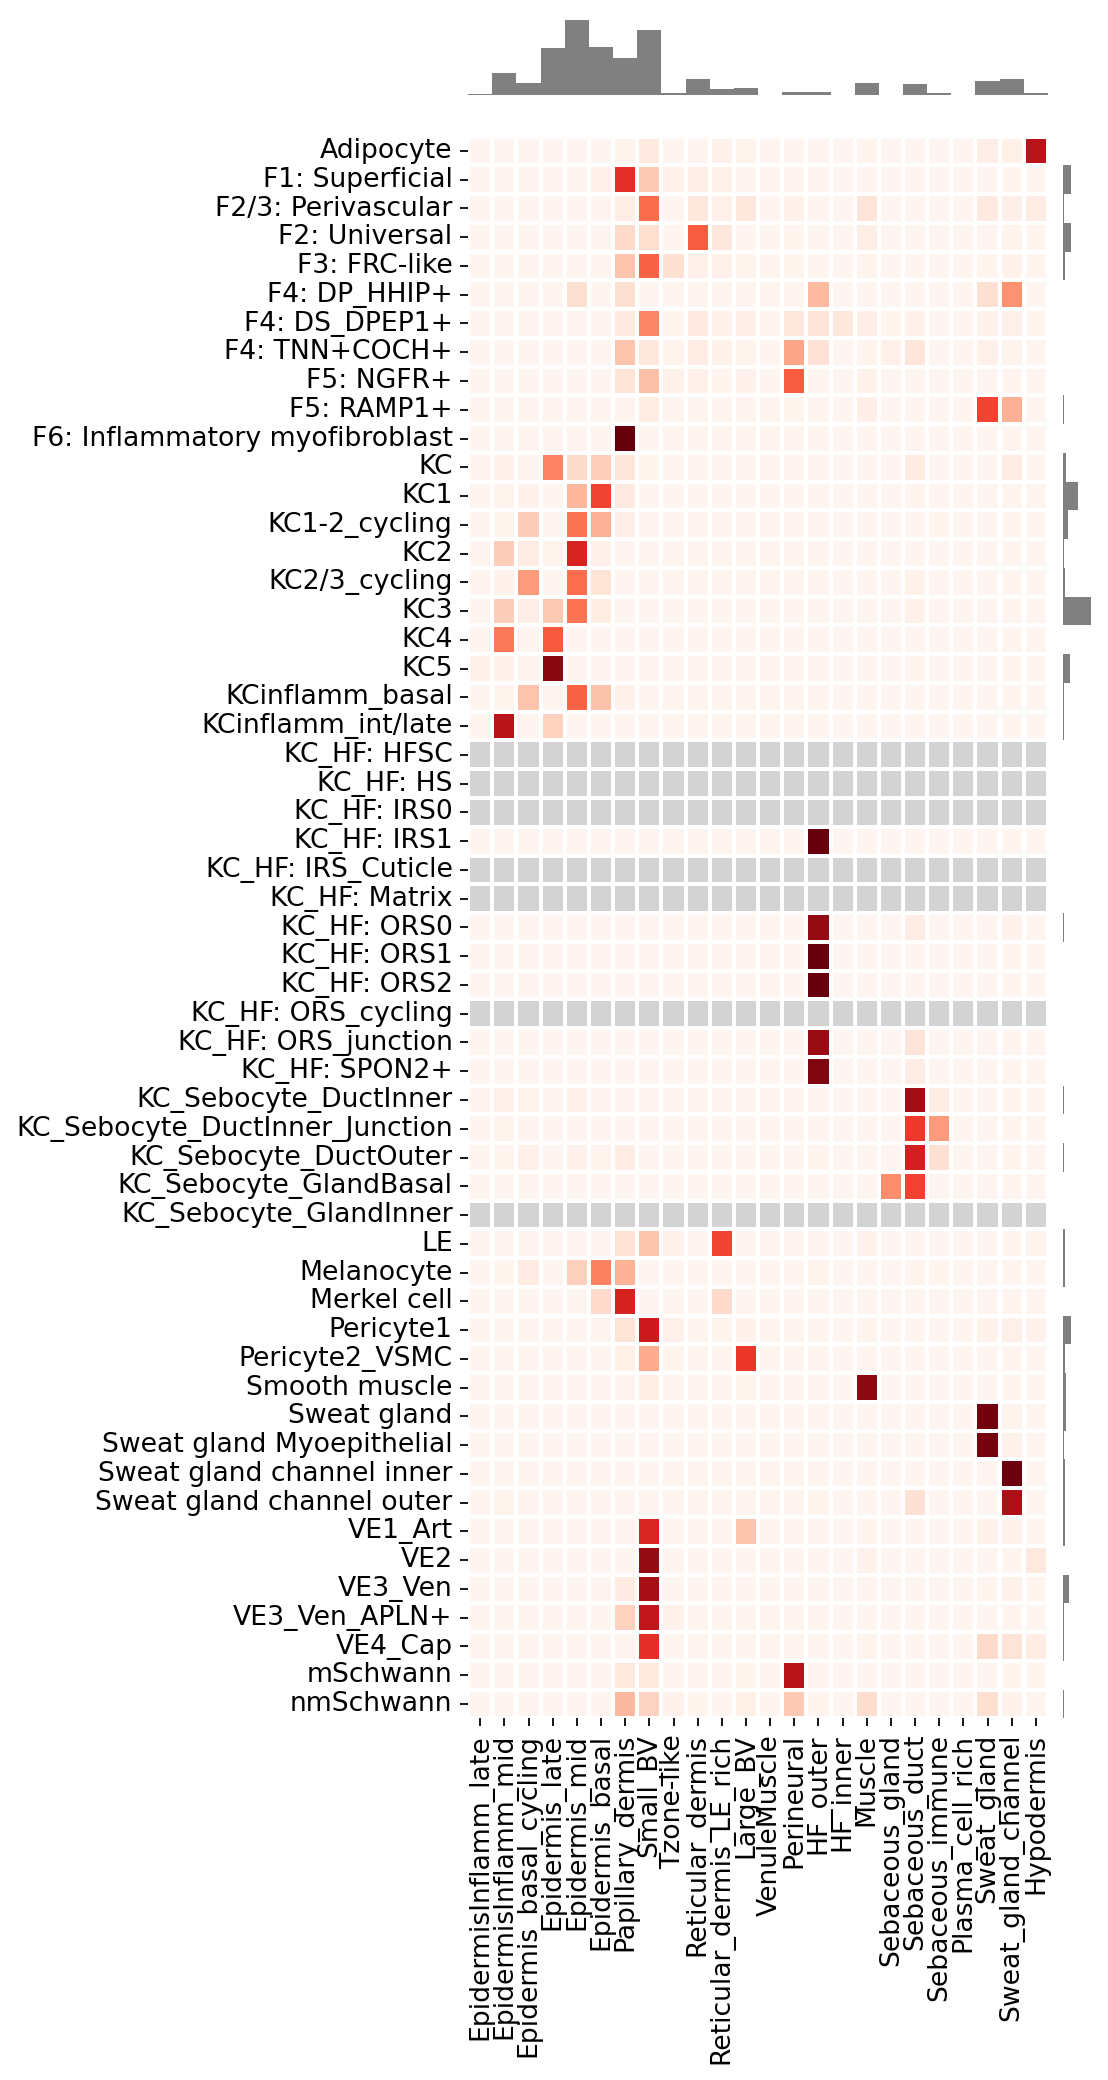

Psoriasis


/tmp/ipykernel_2797186/329750356.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([NICHE, CATEGORY])
/tmp/ipykernel_2797186/329750356.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


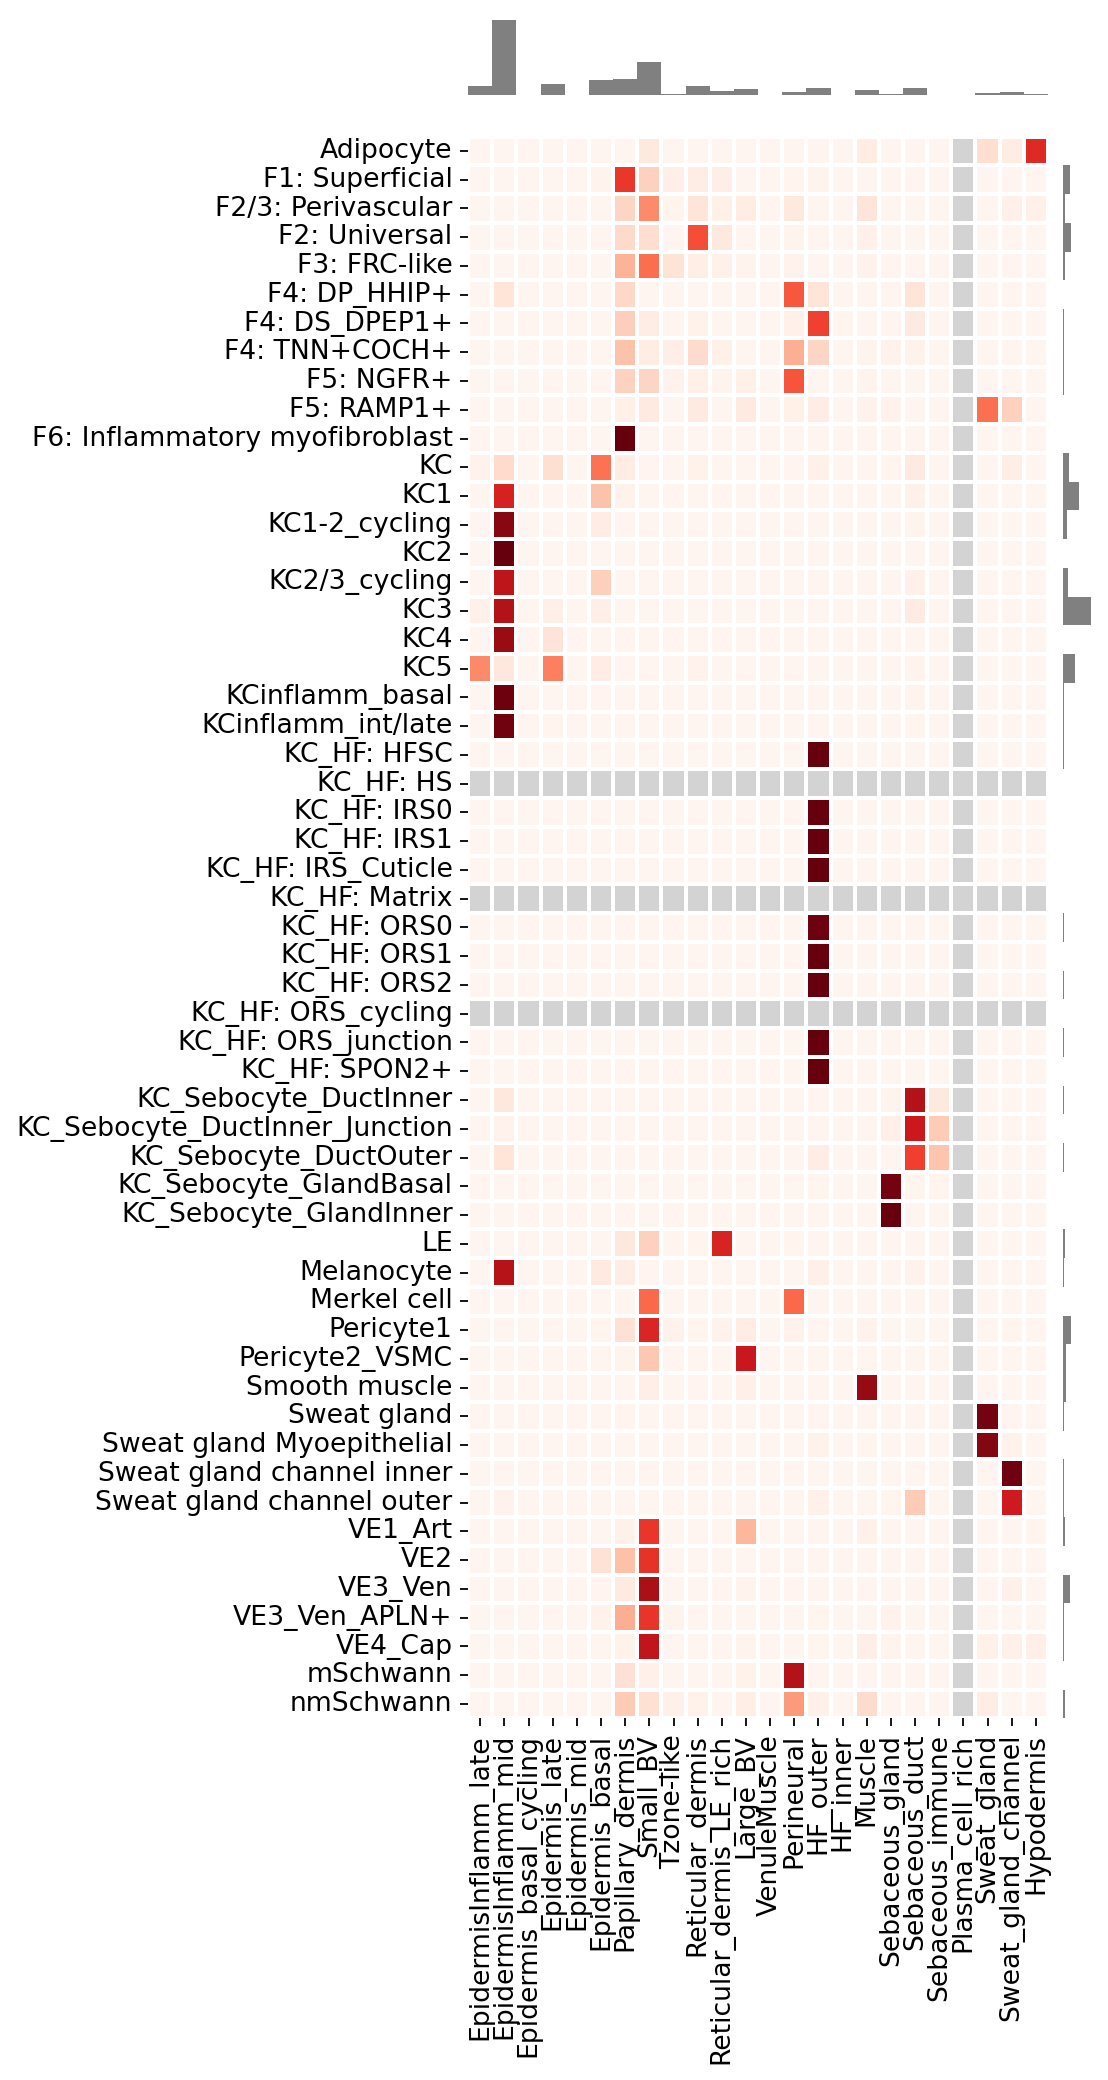

In [32]:
print("Annotations: ", CATEGORY)

# ---- Desired row and column order ----

# desired_order = ["NicheA", "NicheC", "NicheB", "NicheZ"]  # your column order

# Set colormap with grey for NaNs
cmap = mpl.cm.Reds.copy()
cmap.set_bad(color='lightgrey')

for DISEASE in ["AD", "Psoriasis"]:
    print(DISEASE)
    adata_5k_iii = adata_5k_i[adata_5k_i.obs["disease_overall"] == DISEASE]
    
    counts = (
        adata_5k_iii.obs
        .groupby([NICHE, CATEGORY])
        .size()
        .reset_index(name="count")
    )
    heatmap_data = counts.pivot(index=CATEGORY, columns=NICHE, values="count")
    heatmap_data = heatmap_data.reindex(index=all_cell_types, columns=desired_order).fillna(np.nan)
    

    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)


    # assume heatmap_data, cmap, adata_5k_iii are defined

    # raw counts
    col_counts = (
        adata_5k_iii.obs[NICHE]
        .value_counts()
        .reindex(heatmap_data.columns)
        .fillna(0)
    )
    row_counts = (
        adata_5k_iii.obs[CATEGORY]
        .value_counts()
        .reindex(heatmap_data.index)
        .fillna(0)
    )

    # figure + grid
    fig = plt.figure(figsize=(5
                              ,14))
    gs = gridspec.GridSpec(
        2, 2,
        height_ratios=[0.2, 4],  # First value controls top bar height (was 1), make it smaller
        width_ratios=[4, 0.2],   # Second value controls right bar width (was 1), make it smaller
        hspace=0.05, wspace=0.05
    )

    ax_colbar = fig.add_subplot(gs[0,0])
    ax_empty  = fig.add_subplot(gs[0,1])
    ax_heat   = fig.add_subplot(gs[1,0])
    ax_rowbar = fig.add_subplot(gs[1,1])

    ax_empty.axis('off')

    # 1) niche12 bar (top), no text
    x = np.arange(len(col_counts))
    ax_colbar.bar(x, col_counts.values, color='gray', width=1, align='edge')
    ax_colbar.set_xlim(0, len(col_counts))
    ax_colbar.axis('off')

    # 2) heatmap (no colorbar)
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        ax=ax_heat,
        cbar=False,
        linewidths=1, 
       linecolor='white'
   # linecolor=None 
        
    )
    ax_heat.set_xlabel('', fontsize=14)
    ax_heat.set_ylabel('', fontsize=14)
    ax_heat.set_xticks(x+0.5)
    ax_heat.set_xticklabels(heatmap_data.columns, rotation=90, fontsize=12)
    ax_heat.set_yticks(np.arange(len(heatmap_data.index))+0.5)
    ax_heat.set_yticklabels(heatmap_data.index, fontsize=12)
    ax_heat.set_facecolor('white')  # removes background tint behind NaNs
    # 3) lvl5_annotation bar (right), no text, aligned
    y = np.arange(len(row_counts))
    ax_rowbar.barh(y, row_counts.values, color='gray', height=1, align='edge')
    ax_rowbar.set_ylim(0, len(row_counts))
    ax_rowbar.invert_yaxis()
    ax_rowbar.axis('off')

    plt.tight_layout()
    plt.savefig(f"supp/5a_{DISEASE}_nonimmuneniches_grid.pdf", dpi=300, bbox_inches="tight")
    plt.show()